### Summary for the classification task
- The Bird Species dataset sourced from [Kaggle](https://www.kaggle.com/gpiosenka/100-bird-species) serves as the primary data source.
- To streamline the training process, the focus is narrowed down to a subset of the dataset containing images of 15 distinct bird species.
- These 15 bird species were selected through a thoughtful process which took into account the practicality of training. Specifically, species were chosen if they met the criterion of having a significant number of images (more than 200 instances) available for analysis. Moreover, to ensure balanced representation and equitable training across the categories, only species with a comparable number of images were included.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.models as models
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [61]:
train_path = "/kaggle/input/15-species/train"
val_path = "/kaggle/input/15-species/valid"
test_path = "/kaggle/input/15-species/test" 

batch_size = 8

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_folder = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
valid_folder = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
test_folder = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
train_ds = DataLoader(train_folder, batch_size=batch_size, shuffle=True) # shuffle training data
valid_ds = DataLoader(valid_folder, batch_size=batch_size, shuffle=False)
test_ds = DataLoader(test_folder, batch_size=batch_size, shuffle=False)

In [70]:
# check the first batch
for image, label in train_ds:
    print(image.shape)
    print(label.shape)
    break

torch.Size([8, 3, 224, 224])
torch.Size([8])


In [18]:
print(train_folder.classes)
print(len(train_folder.classes))
print(len(train_folder))

['DARK EYED JUNCO', 'EASTERN YELLOW ROBIN', 'FRILL BACK PIGEON', 'GREATER PRAIRIE CHICKEN', 'JACOBIN PIGEON', 'LAUGHING GULL', 'MERLIN', 'MILITARY MACAW', 'ORNATE HAWK EAGLE', 'OYSTER CATCHER', 'PYRRHULOXIA', 'RED TAILED HAWK', 'VIOLET BACKED STARLING', 'VIOLET GREEN SWALLOW', 'YELLOW BREASTED CHAT']
15
3077


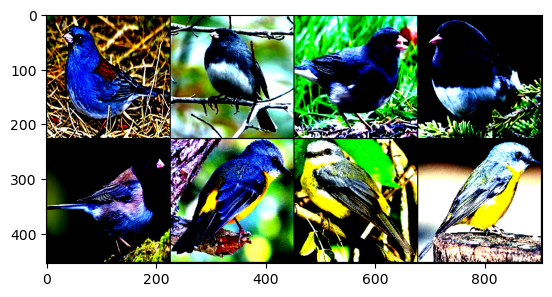

In [63]:
im = make_grid(image, nrow=4)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [5]:
# define the convolutional neural network architecture
# input size: 3x224x224
# output size: 15

class BirdClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BirdClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),  # # 224/2/2/2=28
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout layer with a probability of 0.5
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # flatten layer
        x = self.fc_layers(x)
        return x

In [6]:
model = BirdClassifier(15)

In [66]:
epoch = 50

torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
torch.cuda.empty_cache()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []

epochs = epochs

for epoch in range(epochs):
    # training loop
    
    for X_train, y_train in train_ds: # iternate through all batches of training data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        # Forward pass
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
       
        # Back propagation and update
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    train_losses.append(train_loss.item()) # add training loss during the last batch for each epoch
    print(f"Epoch {epoch+1}/{epochs}, training loss {train_loss.item():.4f}")
    
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for X_train, y_train in test_ds: # iterate over all batches of test data
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            
            y_pred = model(X_train)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
    print(f"train eval: {correct}/{total} accuracy {correct/total*100:.2f}%\n")
    
    # testing loop
    total = 0
    correct = 0
    with torch.no_grad():
        for X_test, y_test in test_ds: # iterate over all batches of test data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            y_pred = model(X_test)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    
    test_loss = criterion(y_pred, y_test)
    test_losses.append(test_loss.item()) # add test loss during the last batch for each epoch
    print(f"test eval: {correct}/{total} accuracy {correct/total*100:.2f}%\n")
    model.train()

Epoch 1/50, training loss 3.0635
train eval: 35/75 accuracy 46.67%

test eval: 37/75 accuracy 49.33%

Epoch 2/50, training loss 1.2703
train eval: 41/75 accuracy 54.67%

test eval: 41/75 accuracy 54.67%

Epoch 3/50, training loss 1.1087
train eval: 46/75 accuracy 61.33%

test eval: 43/75 accuracy 57.33%

Epoch 4/50, training loss 1.6857
train eval: 48/75 accuracy 64.00%

test eval: 46/75 accuracy 61.33%

Epoch 5/50, training loss 2.5284
train eval: 51/75 accuracy 68.00%

test eval: 52/75 accuracy 69.33%

Epoch 6/50, training loss 0.0797
train eval: 54/75 accuracy 72.00%

test eval: 53/75 accuracy 70.67%

Epoch 7/50, training loss 2.4119
train eval: 53/75 accuracy 70.67%

test eval: 51/75 accuracy 68.00%

Epoch 8/50, training loss 1.3099
train eval: 51/75 accuracy 68.00%

test eval: 53/75 accuracy 70.67%

Epoch 9/50, training loss 2.1379
train eval: 52/75 accuracy 69.33%

test eval: 54/75 accuracy 72.00%

Epoch 10/50, training loss 1.9247
train eval: 50/75 accuracy 66.67%

test eval: 55

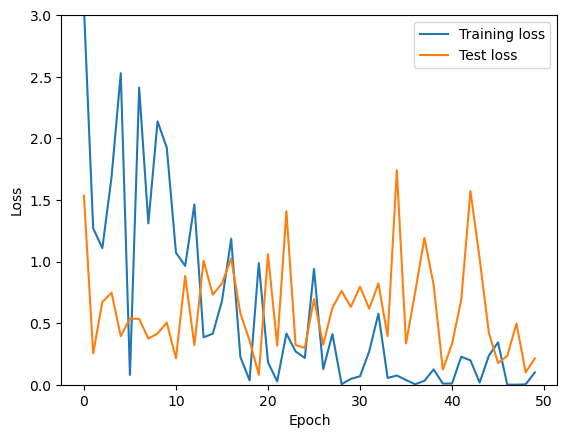

In [67]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3) # scale the y-axis to start at 0
plt.legend()
plt.show()

In [68]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for X_test, y_test in test_ds: # iterate over all batches of test data
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        y_pred = model(X_test)
        _, predicted = torch.max(y_pred.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

print(f"test eval: {correct}/{total} accuracy {correct/total*100:.2f}%")

test eval: 66/75 accuracy 88.00%


In [69]:
# test with validation set
valid_total= 0
valid_correct = 0
with torch.no_grad():
    for X_valid, y_valid in valid_ds:
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        
        y_pred = model(X_valid)
        _, predicted = torch.max(y_pred.data, 1)
        valid_total += y_valid.size(0)
        valid_correct += (predicted == y_valid).sum().item()

print(f"validation eval: {valid_correct}/{valid_total} accuracy {valid_correct/valid_total*100:.2f}%")

validation eval: 60/75 accuracy 80.00%


In [37]:
import requests
import PIL
from PIL import Image

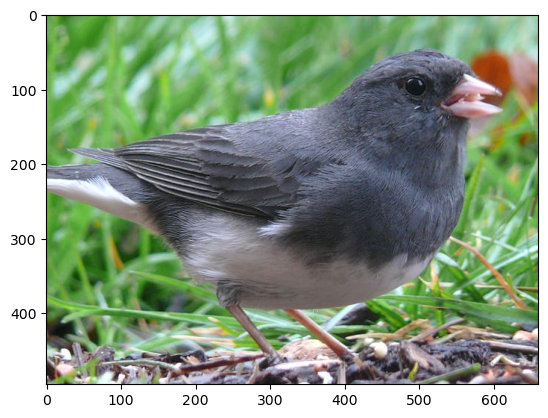

In [38]:
# google search "DARK EYED JUNCO"
url = 'https://www.providencejournal.com/gcdn/authoring/2017/12/21/NPRJ/ghows-PJ-60dc6d91-9420-756c-e053-0100007f0cba-47db302d.jpeg?width=660&height=496&fit=crop&format=pjpg&auto=webp'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [39]:
classes = ['DARK EYED JUNCO', 'EASTERN YELLOW ROBIN', 'FRILL BACK PIGEON', 'GREATER PRAIRIE CHICKEN', 'JACOBIN PIGEON', 'LAUGHING GULL', 'MERLIN', 'MILITARY MACAW', 'ORNATE HAWK EAGLE', 'OYSTER CATCHER', 'PYRRHULOXIA', 'RED TAILED HAWK', 'VIOLET BACKED STARLING', 'VIOLET GREEN SWALLOW', 'YELLOW BREASTED CHAT']
x = test_transform(img) 
image = x.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

DARK EYED JUNCO
